In [1]:
import os

import time

import numpy as np

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

2024-05-27 14:03:10.643723: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 14:03:10.673866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 14:03:10.673894: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 14:03:10.673907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 14:03:10.679373: I tensorflow/core/platform/cpu_feature_g

In [2]:
print(tf.__version__)

2.14.0


In [3]:
import matplotlib.pyplot as plt

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 12  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 15  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 17  # Font size of titlea


In [4]:
def logit(p):

	return tf.math.log(p/(1-p))

In [5]:
logit(0.8)

2024-05-27 14:03:14.740826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 14:03:15.062098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 14:03:15.062162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 14:03:15.067806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 14:03:15.067853: I tensorflow/compile

<tf.Tensor: shape=(), dtype=float32, numpy=1.3862944>

In [6]:
tf.math.sigmoid(logit(0.8))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

# Spatial SIS

In [7]:
os.chdir("script/")
%run -i synthetic.py
%run -i CAL.py
os.chdir("../")

In [8]:
N_pop = 1000
covariates = tf.convert_to_tensor(np.load("data/covariates.npy"), dtype = tf.float32)[:N_pop,:]
locations  = tf.convert_to_tensor(np.load("data/locations.npy"), dtype = tf.float32)[:N_pop,:]

parameters = {"prior_infection":tf.convert_to_tensor([1-0.003, 0.003], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-1.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "log_phi":tf.math.log(
                tf.convert_to_tensor([2.], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),}

SIS = spatial_SIS(locations, covariates)

2024-05-27 14:03:19.661436: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x98ad0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-27 14:03:19.661498: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-05-27 14:03:19.679790: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:104] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. split_seed/sanitize_seed/seed
2024-05-27 14:03:19.694654: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-27 14:03:19.964277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907

2024-05-27 14:03:22.367033: I ./tensorflow/compiler/jit/device_comp

3.072711229324341


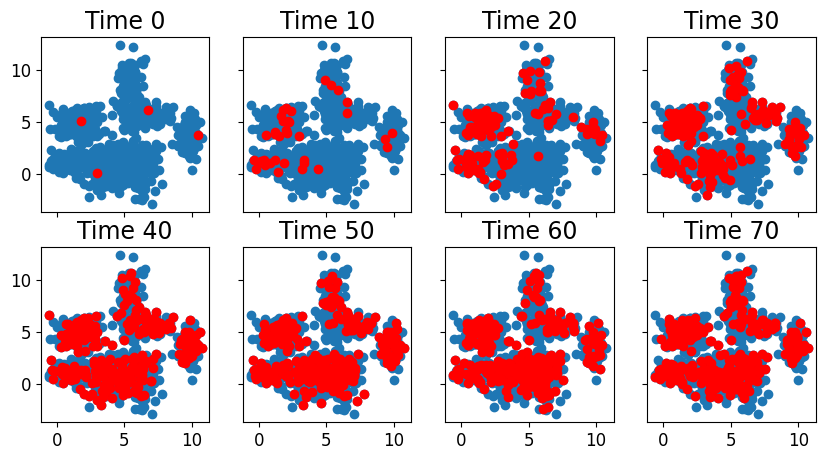

In [9]:
T    = 100
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
    for j in range(4):

        t = 10*(i*4+j)

        infected = tf.where(X[t,:,1]==1)[:,0]

        ax[i, j].set_title("Time "+str(t))
        ax[i, j].scatter(locations[:,0], locations[:,1])
        ax[i, j].scatter(tf.gather(locations[:,0], infected),
                         tf.gather(locations[:,1], infected), color = "red")

In [10]:
KL_list = []

for i in range(100):

	print(i)
	X, Y = simulator(SIS, parameters, T)

	# while tf.reduce_sum(X, axis = [0, 1])[1]<10:
	# 	X, Y = simulator(SIS, parameters, T)

	p_X_Y = joint_likelihood(SIS, parameters, X, Y)
	CAL_p_X_Y = CAL_joint_likelihood(SIS, parameters, X, Y)

	KL_list.append(tf.reduce_sum(tf.math.log(p_X_Y/CAL_p_X_Y)))

In [11]:
KL_sample = []
for i in range(len(KL_list)):

	sample = tf.concat((tf.stack(KL_list[:i]), tf.stack(KL_list[i+1:])), axis = 0)
	KL_sample.append(-tf.reduce_mean(sample)/N_pop)

print(str(tf.reduce_mean(KL_sample).numpy())+"+/-"+str(tf.math.reduce_std(KL_sample).numpy()))

NameError: name 'KL_list' is not defined

In [12]:
N_pop = 10000
covariates = tf.convert_to_tensor(np.load("data/covariates.npy"), dtype = tf.float32)[:N_pop,:]
locations  = tf.convert_to_tensor(np.load("data/locations.npy"), dtype = tf.float32)[:N_pop,:]

parameters = {"prior_infection":tf.convert_to_tensor([1-0.003, 0.003], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-1.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "log_phi":tf.math.log(
                tf.convert_to_tensor([2.], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),}

SIS = spatial_SIS(locations, covariates)

3.1113996505737305


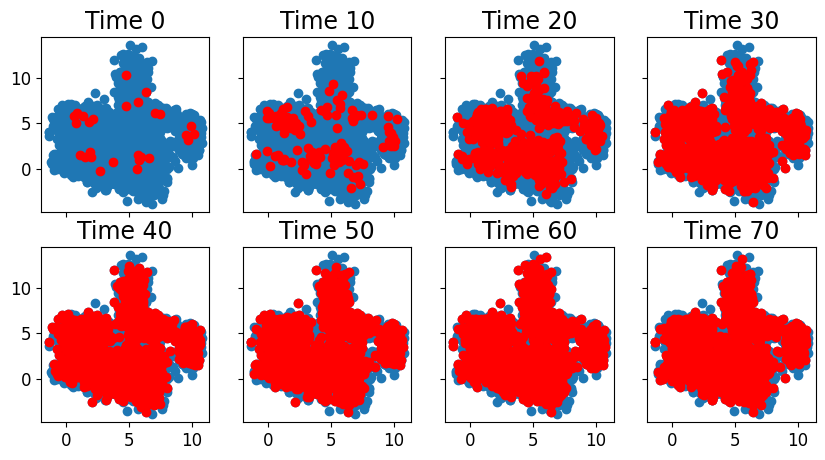

In [13]:
T    = 100
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
    for j in range(4):

        t = 10*(i*4+j)

        infected = tf.where(X[t,:,1]==1)[:,0]

        ax[i, j].set_title("Time "+str(t))
        ax[i, j].scatter(locations[:,0], locations[:,1])
        ax[i, j].scatter(tf.gather(locations[:,0], infected),
                         tf.gather(locations[:,1], infected), color = "red")

In [127]:
KL_list = []

for i in range(100):

	print(i)
	X, Y = simulator(SIS, parameters, T)

	# while tf.reduce_sum(X, axis = [0, 1])[1]<10:
	# 	X, Y = simulator(SIS, parameters, T)

	p_X_Y = joint_likelihood(SIS, parameters, X, Y)
	CAL_p_X_Y = CAL_joint_likelihood(SIS, parameters, X, Y)

	KL_list.append(tf.reduce_sum(tf.math.log(p_X_Y/CAL_p_X_Y)))

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [128]:
KL_sample = []
for i in range(len(KL_list)):

	sample = tf.concat((tf.stack(KL_list[:i]), tf.stack(KL_list[i+1:])), axis = 0)
	KL_sample.append(-tf.reduce_mean(sample)/N_pop)

print(str(tf.reduce_mean(KL_sample).numpy())+"+/-"+str(tf.math.reduce_std(KL_sample).numpy()))

0.032596514+/-0.00034678754
